In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS

# Load relevant datasets as dataframes
educ_df = pd.read_csv('educ_data.csv')
gini_df = pd.read_csv('gini_data.csv')
unemp_df = pd.read_csv('unemp_data.csv')
world_bank_df = pd.read_csv('world_bank_data.csv')

In [16]:
year_columns = [str(year) + ' [YR' + str(year) + ']' for year in range(1960, 2024)]

# Melt the DataFrame to make years as rows
world_bank_melted_df = world_bank_df.melt(
    id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Value'
)
# Drop rows with no data
world_bank_melted_df = world_bank_melted_df[world_bank_melted_df['Value'] != '..']

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
world_bank_melted_df['Year'] = world_bank_melted_df['Year'].str.extract('(\d+)').astype(int)
world_bank_melted_df['Value'] = pd.to_numeric(world_bank_melted_df['Value'], errors='coerce')

# Pivot the DataFrame without dropping the Year column
world_bank_pivot_df = world_bank_melted_df.pivot_table(index=['Country Name', 'Country Code', 'Year'], 
                                                 columns='Series Name', 
                                                 values='Value', 
                                                 fill_value=0).reset_index()

# Rename selected columns
world_bank_pivot_df.rename(columns={
    "Population living in slums (% of urban population)": "Slum Population (%)",
    "High-technology exports (% of manufactured exports)": "High-tech Exports (%)",
    "Political Stability and Absence of Violence/Terrorism: Estimate": "Pol Stability",
    "Individuals using the Internet (% of population)": "Internet Use (%)",
    "Government Effectiveness: Estimate": "Govt Eff",
    "Control of Corruption: Estimate": "Control Corr",
    "Social contributions (current LCU)": "Soc Cont",
    "Share of youth not in education, employment or training, total (% of youth population)": "Unproductive Youth (%)"
}, inplace=True)

world_bank_pivot_df.head()

Series Name,Country Name,Country Code,Year,Control Corr,Govt Eff,High-tech Exports (%),Internet Use (%),"Individuals using the Internet, female (% of female population)","Individuals using the Internet, male (% of male population)",Mobile cellular subscriptions (per 100 people),...,Population density (people per sq. km of land area),Population in the largest city (% of urban population),Population in urban agglomerations of more than 1 million (% of total population),Slum Population (%),Refugee population by country or territory of asylum,Rule of Law: Estimate,"Share of youth not in education, employment or training, female (% of female youth population)","Share of youth not in education, employment or training, male (% of male youth population)",Unproductive Youth (%),Soc Cont
0,Afghanistan,AFG,1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,39.392965,3.309401,0.0,0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,AFG,1961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.477056,39.348203,3.416999,0.0,0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,AFG,1962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.751356,39.273621,3.525202,0.0,0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,AFG,1963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.040239,39.181890,3.634510,0.0,0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,AFG,1964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.343888,39.069378,3.745192,0.0,0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Extract columns of interest to be merged
columns_of_interest = [
    "Country Name",
    "Country Code",
    "Year",
    "Slum Population (%)",
    "High-tech Exports (%)",
    "Pol Stability",
    "Internet Use (%)",
    "Govt Eff",
    "Control Corr",
    "Soc Cont",
    "Unproductive Youth (%)"
]

vars_of_interest = [
    "Slum Population (%)",
    "High-tech Exports (%)",
    "Pol Stability",
    "Internet Use (%)",
    "Govt Eff",
    "Control Corr",
    "Soc Cont",
    "Unproductive Youth (%)"
]

world_bank_subset_df = world_bank_pivot_df[columns_of_interest]

world_bank_subset_df = world_bank_subset_df[
    (world_bank_subset_df['Year'] >= 2007) & 
    (world_bank_subset_df['Year'] <= 2024)
]

world_bank_subset_df.head()

Series Name,Country Name,Country Code,Year,Slum Population (%),High-tech Exports (%),Pol Stability,Internet Use (%),Govt Eff,Control Corr,Soc Cont,Unproductive Youth (%)
47,Afghanistan,AFG,2007,0.00000,0.0,-2.413373,1.90,-1.440111,-1.613251,3.984663e+08,0.0
48,Afghanistan,AFG,2008,63.60000,0.0,-2.691361,1.84,-1.527795,-1.672096,7.519804e+08,0.0
49,Afghanistan,AFG,2009,0.00000,0.0,-2.711421,3.55,-1.507752,-1.552299,9.744476e+08,0.0
50,Afghanistan,AFG,2010,64.80761,0.0,-2.579152,4.00,-1.478316,-1.645391,1.650460e+09,0.0
51,Afghanistan,AFG,2011,0.00000,0.0,-2.502060,5.00,-1.474100,-1.600471,2.735434e+09,0.0


In [18]:
count_with_data = world_bank_subset_df.apply(lambda col: col.notna() & (col != 0) & (col != '..')).sum()

print(count_with_data)

Series Name
Country Name              4448
Country Code              4448
Year                      4448
Slum Population (%)        857
High-tech Exports (%)     2860
Pol Stability             3273
Internet Use (%)          4001
Govt Eff                  3257
Control Corr              3258
Soc Cont                   933
Unproductive Youth (%)    1871
dtype: int64


only got data from 2007 onwards

In [19]:
# Clean unemp_df
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']  
year_columns = unemp_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
unemp_df = pd.melt(unemp_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Unemp %')

# Drop rows with no data
unemp_df = unemp_df.dropna(subset=['Unemp %'])

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
unemp_df['Year'] = unemp_df['Year'].str.extract('(\d+)').astype(int)

# Clean educ_df
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']  
year_columns = educ_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
educ_df = pd.melt(educ_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Average years of schooling')

# Drop rows with no data
educ_df = educ_df[educ_df['Average years of schooling'] != '..']

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
educ_df['Year'] = educ_df['Year'].str.extract('(\d+)').astype(int)

# Clean gini_df

gini_df["iso"] = gini_df["iso"].transform(lambda x: x.upper())
gini_df['gini_recalculated'] = pd.to_numeric(gini_df['gini_recalculated'], errors='coerce')
gini_df = gini_df.dropna(subset=['gini_recalculated'])

In [20]:
merged_df = pd.merge(gini_df,unemp_df,left_on=["iso","year"],right_on=["Country Code","Year"])
merged_df = pd.merge(merged_df,educ_df,left_on=["iso","year"],right_on=["Country Code","Year"])

merged_df = pd.merge(merged_df,world_bank_subset_df,left_on=["iso","year"],right_on=["Country Code","Year"])

columns_req = ['country',
               'iso',
                'year', 
                'gini_reported',
                'gdp_ppp_pc_usd2011', 
                'population', 
                'gini_recalculated',
                'Unemp %',
                'Series Name',
                'Average years of schooling', 
                "Slum Population (%)",
                "High-tech Exports (%)",
                "Pol Stability",
                "Internet Use (%)",
                "Govt Eff",
                "Control Corr",
                "Soc Cont",
                "Unproductive Youth (%)"
]

merged_df = merged_df[columns_req]
merged_df = merged_df[merged_df['Series Name'].str.contains('both sexes', case=False)]

# Step 2: Drop duplicate rows
merged_df = merged_df.drop_duplicates().reset_index(drop=True)
merged_df.drop(columns=["Series Name"], inplace=True)
merged_df = merged_df.set_index(["country","year"])


In [21]:
merged_df.tail()

iso gini_reported  gdp_ppp_pc_usd2011  population  \
country      year                                                      
South Africa 2012  ZAF       0.63405            12254.00  52832660.0   
             2014  ZAF     0.6444476            12329.33  54471703.0   
             2015  ZAF     0.6496464            12367.00  55291225.0   
Zimbabwe     2012  ZWE     0.4499857             1943.00  14386649.0   
             2014  ZWE     0.4499857             1943.00  14386649.0   

                   gini_recalculated  Unemp % Average years of schooling  \
country      year                                                          
South Africa 2012           0.634050   21.786                    9.97053   
             2014           0.635906   22.606                   10.18879   
             2015           0.649646   22.869                   10.27425   
Zimbabwe     2012           0.449555    5.057                    7.89256   
             2014           0.449555    4.774                     8.2014   

                   Slum Population (%)  High-tech Exports (%)  Pol Stability  \
country      year                                                              
South Africa 2012             25.32466               6.685681      -0.025387   
             2014             24.94382               6.659056      -0.146389   
             2015              0.00000               7.426564      -0.220545   
Zimbabwe     2012             23.94962               6.219771      -0.778662   
             2014             23.35427               1.461771      -0.713570   

                   Internet Use (%)  Govt Eff  Control Corr   Soc Cont  \
country      year                                                        
South Africa 2012           41.0000  0.170115     -0.184171        0.0   
             2014           49.0000  0.165477     -0.124875        0.0   
             2015           51.9191  0.087739     -0.070510        0.0   
Zimbabwe     2012           12.0000 -1.373752     -1.381803  2149982.5   
             2014           16.3647 -1.279434     -1.404367        0.0   

                   Unproductive Youth (%)  
country      year                          
South Africa 2012                   0.000  
             2014                  31.313  
             2015                  30.499  
Zimbabwe     2012                   0.000  
             2014                  16.561

In [22]:
merged_df.head()

iso gini_reported  gdp_ppp_pc_usd2011  population  \
country   year                                                      
Angola    2014  AGO     0.4445348             6283.00  22549547.0   
Albania   2008  ALB   0.319450431             8986.00   3002683.0   
          2011  ALB   0.312414251             9987.25   2936239.0   
          2012  ALB   0.310068857            10321.00   2914091.0   
Argentina 2008  ARG      0.422675            18576.00  40080160.0   

                gini_recalculated  Unemp % Average years of schooling  \
country   year                                                          
Angola    2014           0.450320   16.401                    3.99596   
Albania   2008           0.319450   13.060                    9.16803   
          2011           0.314103   13.481                    9.90485   
          2012           0.310069   13.376                   10.14573   
Argentina 2008           0.422675    7.837                   10.51253   

                Slum Population (%)  High-tech Exports (%)  Pol Stability  \
country   year                                                              
Angola    2014             50.31801               0.000000      -0.333232   
Albania   2008             17.90000               0.000000      -0.030501   
          2011              0.00000               1.016873      -0.282379   
          2012             12.90000               0.922637      -0.143632   
Argentina 2008             17.38930               9.327914      -0.087756   

                Internet Use (%)  Govt Eff  Control Corr      Soc Cont  \
country   year                                                           
Angola    2014           21.3623 -1.055904     -1.457798  8.685631e+10   
Albania   2008           23.8600 -0.367063     -0.605212  0.000000e+00   
          2011           47.0000 -0.202177     -0.701794  0.000000e+00   
          2012           49.4000 -0.268925     -0.778729  0.000000e+00   
Argentina 2008           28.1126 -0.123509     -0.434875  9.251800e+09   

                Unproductive Youth (%)  
country   year                          
Angola    2014                  30.622  
Albania   2008                  28.166  
          2011                  30.011  
          2012                  27.654  
Argentina 2008                  19.421

In [23]:
# Count occurrences of each year in the 'year' level of the multi-index
year_counts = merged_df.index.get_level_values('year').value_counts()

# Display the year with the most entries
most_common_year = year_counts.idxmax()
most_common_year_count = year_counts.max()

print(f"The year with the most entries is {most_common_year} with {most_common_year_count} entries.")
print(year_counts)  # This will show the counts for all years

The year with the most entries is 2011 with 75 entries.
2011    75
2010    72
2014    67
2012    67
2009    63
2015    63
2008    62
2013    56
2007    52
Name: year, dtype: int64


In [24]:
# Filter for rows where the 'year' level in the index is 2011
filtered_df = merged_df[merged_df.index.get_level_values('year') == 2011]

# Display the first few rows of the filtered DataFrame
filtered_df.head()

,,iso,gini_reported,gdp_ppp_pc_usd2011,population,gini_recalculated,Unemp %,Average years of schooling,Slum Population (%),High-tech Exports (%),Pol Stability,Internet Use (%),Govt Eff,Control Corr,Soc Cont,Unproductive Youth (%)
country,year,,,,,,,,,,,,,,,
Albania,2011,ALB,0.312414251,9987.25,2936239.0,0.314103,13.481,9.90485,0.0,1.016873,-0.282379,47.0000,-0.202177,-0.701794,0.000000e+00,30.011
Argentina,2011,ARG,0.40789,19789.00,41320496.0,0.407890,7.180,10.79015,0.0,7.321190,0.158994,51.0000,-0.072361,-0.364099,1.928960e+10,18.405
Armenia,2011,ARM,0.313722885,7022.00,2875581.0,0.313723,11.534,11.30916,0.0,3.373336,-0.063869,32.0000,-0.115028,-0.664559,0.000000e+00,37.223
Australia,2011,AUS,0.283,41704.00,22479799.0,0.286850,5.083,12.49883,0.0,17.943549,0.935710,79.4877,1.690138,2.037909,0.000000e+00,10.590
Austria,2011,AUT,0.30117,44127.00,8453501.0,0.301170,4.637,11.7306,0.0,13.255327,1.193522,78.7400,1.602885,1.470289,7.405750e+09,10.559


In [25]:
# Convert columns to numeric, coerce errors to handle non-numeric data
X = np.log(filtered_df[['gdp_ppp_pc_usd2011', 'Unemp %', 'Average years of schooling']].apply(pd.to_numeric, errors='coerce'))
y = np.log(filtered_df['gini_recalculated'])

# Drop rows with NaN values in either X or y
X = X.dropna()
y = y.loc[X.index]  # Ensure y matches the index of X after dropping NaNs

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      gini_recalculated   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.247
Date:                Tue, 05 Nov 2024   Prob (F-statistic):             0.0269
Time:                        12:06:08   Log-Likelihood:                 11.969
No. Observations:                  75   AIC:                            -15.94
Df Residuals:                      71   BIC:                            -6.668
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [26]:
# Count the number of observations for each country and sort in descending order
country_counts = merged_df.groupby('country').size().sort_values(ascending=False)

# Find the country with the most years of observations
most_observed_country = country_counts.idxmax()
most_observed_count = country_counts.max()

print(f"The country with the most years of observations is {most_observed_country} with {most_observed_count} years.")
print(country_counts)  # Display the sorted counts for all countries


The country with the most years of observations is Denmark with 9 years.
country
Denmark                  9
Slovenia                 9
Colombia                 9
Cyprus                   9
Czech Republic           9
                        ..
Lebanon                  1
Sao Tome and Principe    1
Saudi Arabia             1
Cuba                     1
Samoa                    1
Length: 130, dtype: int64


In [27]:
# Extract data for Portugal from the multi-level DataFrame
portugal_df = merged_df.xs('Portugal', level='country')

portugal_df.head(20)

,iso,gini_reported,gdp_ppp_pc_usd2011,population,gini_recalculated,Unemp %,Average years of schooling,Slum Population (%),High-tech Exports (%),Pol Stability,Internet Use (%),Govt Eff,Control Corr,Soc Cont,Unproductive Youth (%)
year,,,,,,,,,,,,,,,
2007,PRT,0.35817,27497.0,10573150.0,0.35817,7.966,7.582,0.0,8.602782,0.821809,42.0900,0.894494,1.028803,6.707567e+09,11.157
2008,PRT,0.35673,27494.0,10595312.0,0.35673,7.553,7.68958,0.0,8.236168,0.987546,44.1300,1.077385,1.059230,6.906509e+09,10.231
2009,PRT,0.34075,26653.0,10604066.0,0.34075,9.432,7.83082,0.0,4.794440,0.787382,48.2700,1.152205,1.085583,7.203101e+09,11.207
2010,PRT,0.34969,27179.0,10596055.0,0.34969,10.771,7.95701,0.0,4.073103,0.717687,53.3000,0.981475,1.062664,7.061101e+09,11.438
2011,PRT,0.35408,26750.0,10569388.0,0.35408,12.682,8.16437,0.0,4.123860,0.741739,55.2500,0.921246,1.081252,6.725501e+09,12.552
2012,PRT,0.35176,25778.0,10526308.0,0.35176,15.531,8.37368,0.0,4.492891,0.775273,60.3400,1.001915,0.955448,5.422160e+09,13.909
2013,PRT,0.35378,25616.0,10473025.0,0.35378,16.188,8.52837,0.0,4.700112,0.748763,62.0956,1.194741,0.912236,6.404131e+09,14.071
2014,PRT,0.34734,25981.0,10418224.0,0.34734,13.897,8.99254,0.0,4.880638,0.806274,64.5924,0.984038,0.909682,6.279503e+09,12.282
2015,PRT,0.3469,26581.0,10368346.0,0.34690,12.447,9.11153,0.0,5.079883,0.904213,68.6329,1.158722,0.892669,6.043098e+09,11.269


In [38]:
# Convert columns to numeric, coerce errors to handle non-numeric data
X = np.log(portugal_df[['gdp_ppp_pc_usd2011',
                        'Unemp %',
                        'Average years of schooling',
                        'High-tech Exports (%)',
                        'Pol Stability',
                        'Internet Use (%)',
                        'Govt Eff',
                        'Control Corr',
                        'Unproductive Youth (%)']].apply(pd.to_numeric, errors='coerce'))
y = np.log(portugal_df['gini_recalculated'])

# Drop rows with NaN values in either X or y
X = X.dropna()
y = y.loc[X.index]  # Ensure y matches the index of X after dropping NaNs

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      gini_recalculated   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 05 Nov 2024   Prob (F-statistic):                nan
Time:                        12:17:21   Log-Likelihood:                 264.19
No. Observations:                   9   AIC:                            -510.4
Df Residuals:                       0   BIC:                            -508.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\cheny\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\cheny\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\cheny\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\cheny\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [36]:
# Assuming your DataFrame is called `df` (replace with your actual DataFrame name)
# Define the dependent variable (gini_recalculated) and independent variables
y = merged_df['gini_recalculated']
X = merged_df[['gdp_ppp_pc_usd2011',
                        'Unemp %',
                        'Average years of schooling',
                        'High-tech Exports (%)',
                        'Pol Stability',
                        'Internet Use (%)',
                        'Govt Eff',
                        'Control Corr',
                        'Unproductive Youth (%)']]

# Convert columns to numeric, coerce errors to handle non-numeric data
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Filter out non-positive values to avoid log issues, then apply log transformation
df_cleaned = pd.concat([y, X], axis=1)
df_cleaned = df_cleaned[(df_cleaned > 0).all(axis=1)]  # Keep only rows with all positive values

# Apply log transformation
y_log = np.log(df_cleaned['gini_recalculated'])
X_log = np.log(df_cleaned[['gdp_ppp_pc_usd2011',
                        'Unemp %',
                        'Average years of schooling',
                        'High-tech Exports (%)',
                        'Pol Stability',
                        'Internet Use (%)',
                        'Govt Eff',
                        'Control Corr',
                        'Unproductive Youth (%)']])

# Add the squared term for log of gdp per capita to capture the Kuznets curve
X_log['gdp_ppp_pc_usd2011_squared'] = X_log['gdp_ppp_pc_usd2011'] ** 2

# Add a constant to the model (intercept term)
X_log = sm.add_constant(X_log)

model = PanelOLS(y_log, X_log, entity_effects=True)
results = model.fit(cov_type='robust')

# Print the regression results
print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:      gini_recalculated   R-squared:                        0.0952
Estimator:                   PanelOLS   R-squared (Between):              0.0604
No. Observations:                 255   R-squared (Within):               0.0952
Date:                Tue, Nov 05 2024   R-squared (Overall):              0.0322
Time:                        12:13:50   Log-likelihood                    535.96
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.1581
Entities:                          40   P-value                           0.0217
Avg Obs:                       6.3750   Distribution:                  F(10,205)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             1.7115
                            

bcause BP test fail, use robust

In [37]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Obtain residuals from the model
residuals = results.resids  # Adjust if necessary based on how PanelOLS stores residuals

# Conduct Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_log)

# Extract test results
bp_test_stat = bp_test[0]  # Breusch-Pagan test statistic
bp_p_value = bp_test[1]    # p-value for the test

print(f"Breusch-Pagan test statistic: {bp_test_stat}")
print(f"p-value: {bp_p_value}")


Breusch-Pagan test statistic: 15.629907330531797
p-value: 0.11072821120509926


## 2. Using the ARIMA model for forecasting inequality
ARIMA is a model used for time series forecasting, and we can use this to forecast inequality in various countries.

In order to find the best model for forecasting, we need to determine the parameters of the ARIMA model, namely:

**p: the number of autoregressive terms**

**d: the number of nonseasonal differences needed for stationarity**

**q: the number of lagged forecast errors in the prediction equation.**

### 2.1. Determining parameter d, the number of nonseasonal differences for stationarity

To use an ARIMA model, we need to ensure that the data is stationary by determining and eliminating seasonality by selecting an appropriate parameter d.

The parameter d is the "degree of differencing", which refers to the number of times a series is differenced. For example, if the series value is X_t, then 1 degree of differencing means the new value X_t' = X_t - X_t-1

We use both Autocorrelation Function (ACF) graphs and Augmented Dicky-Fuller tests to determine the number of differences needed (value of d).

#### 2.1.1 ACF graphs allow us to visualise the autocorrelation and hence seasonality

We will start by doing the analysis on Singapore, before conducting it across all countries.

In [7]:
# Clean gini_df
gini_columns_req = ['country', 'iso', 'year', 'gini_recalculated']

gini_df_clean = gini_df[gini_columns_req]
gini_df_clean = gini_df_clean.drop_duplicates().reset_index(drop=True)
gini_df_clean = gini_df_clean.set_index('year')

# Create singapore_df
singapore_df = gini_df_clean.loc[gini_df_clean['country']=='Singapore'].copy()
singapore_df.head()

,country,iso,gini_recalculated
year,,,
1967,Singapore,SGP,0.399908
1968,Singapore,SGP,0.399908
1969,Singapore,SGP,0.399908
1970,Singapore,SGP,0.399908
1971,Singapore,SGP,0.399908


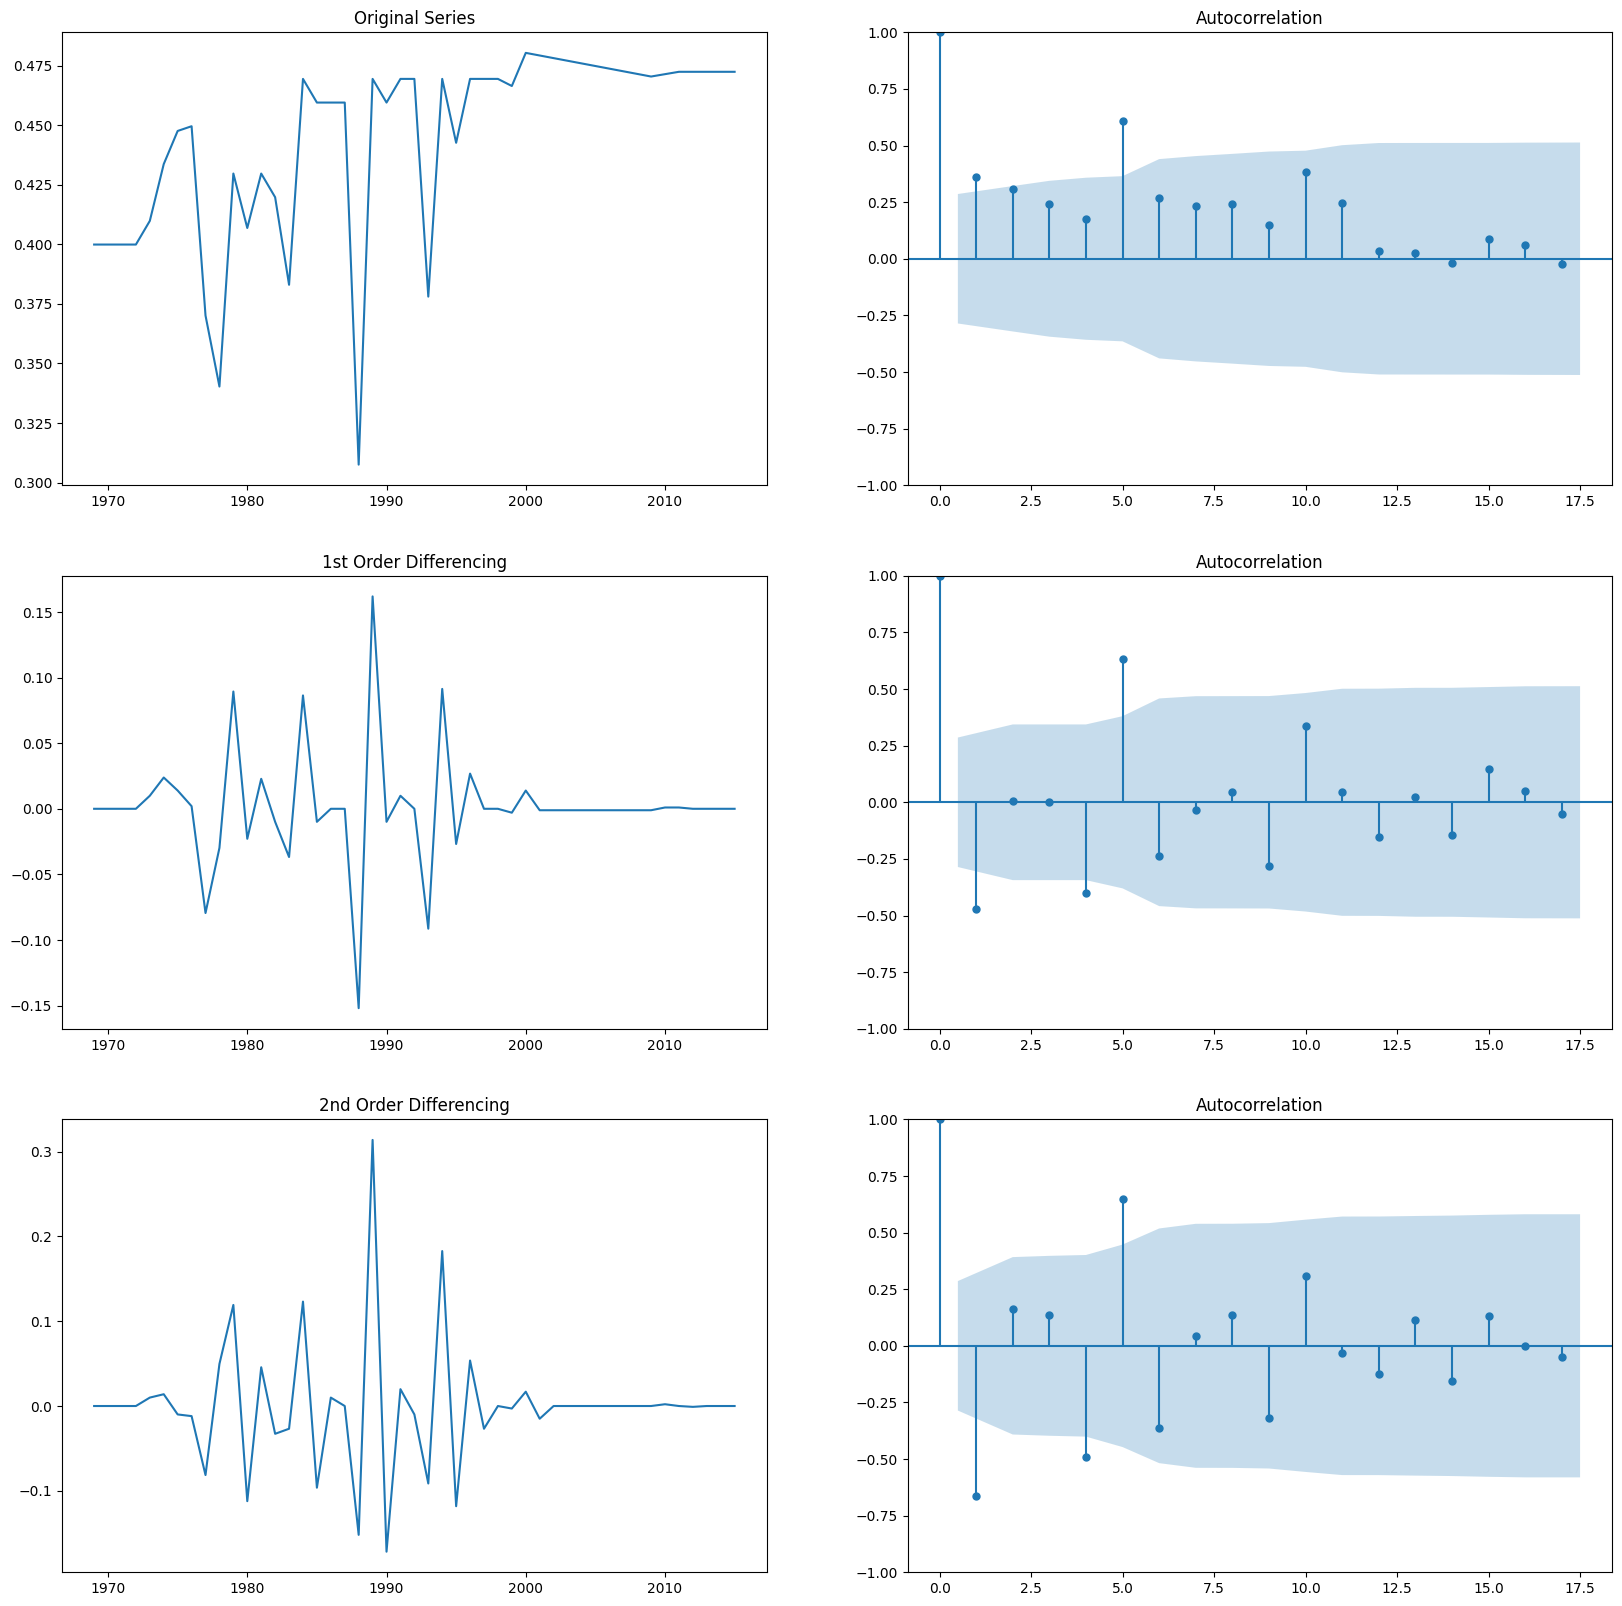

In [8]:
#Plotting ACF graphs

from statsmodels.graphics.tsaplots import plot_acf

# Create dataframes for d = 1 and d = 2 values of gini_recalculated
singapore_df['gini_recalculated_d1'] = singapore_df['gini_recalculated'].diff()
singapore_df['gini_recalculated_d2'] = singapore_df['gini_recalculated'].diff().diff()
singapore_df.dropna(inplace=True)

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(20,20))
axes[0, 0].plot(singapore_df['gini_recalculated'])
axes[0, 0].set_title('Original Series')
plot_acf(singapore_df['gini_recalculated'], ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(singapore_df['gini_recalculated_d1']); axes[1, 0].set_title('1st Order Differencing')
plot_acf(singapore_df['gini_recalculated_d1'], ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(singapore_df['gini_recalculated_d2']); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(singapore_df['gini_recalculated_d2'], ax=axes[2, 1])

plt.show()

The goal of differencing is to reduce autocorrelation trends to obtain stationarity. As seen from the ACF graphs above, d = 0  appears to have a gradual decline on autocorrelation, which is typical when the data is not stationary.

The ACF graph for d = 1 still shows some autocorrelation, but without any trend. Since d = 2 does not change much from d = 1, we will likely use d = 1 to prevent over-differencing.

#### 2.1.2. Augmented Dicky Fuller (ADF) Test
The ADF test is a numerical test for stationarity, to confirm our conclusions from the ACF graph.

In [9]:
#Calculating p-values for Augmented Dicky-Fuller (adfuller) Tests
from statsmodels.tsa.stattools import adfuller

gini_d0 = singapore_df['gini_recalculated'].tolist()
gini_d1 = singapore_df['gini_recalculated_d1'].tolist()
gini_d2 = singapore_df['gini_recalculated_d2'].tolist()

print('The p-value of adfuller test for d = 0 is:', adfuller(gini_d0)[1])
print('The p-value of adfuller test for d = 1 is:', adfuller(gini_d1)[1])
print('The p-value of adfuller test for d = 2 is:', adfuller(gini_d2)[1])


The p-value of adfuller test for d = 0 is: 0.6238813962601757
The p-value of adfuller test for d = 1 is: 1.0343995193247316e-16
The p-value of adfuller test for d = 2 is: 0.00028594779370280367


Since the p-value of the adfuller test is << 0.01 for d = 1, we will use d = 1 in our ARIMA model, which supports our initial hypothesis from the ACF graphs.

### 2.2. Determining the other ARIMA parameters (p and q)
In this section, we determine the number of autoregressive terms (p), and the number of lagged forecast errors  (q)

In [10]:
# Firstly, we split the data into train and test data: We are using 80% of data as training data
# We do not randomise the train & test data as we are comparing the forecast (from the train data) with the test data
# Hence, the test data will have to come chronologically after the train data
# The order of the data is important for time-series analysis

train=singapore_df[:int((80*len(singapore_df))/100)]["gini_recalculated"]
test=singapore_df[int((80*len(singapore_df))/100):]["gini_recalculated"]

print('Total data points:', len(singapore_df))
print('Training data points:',len(train))
print('Testing data points:',len(test))

Total data points: 47
Training data points: 37
Testing data points: 10


In [11]:
#Find all combinations of p, d and q through iteration

from statsmodels.tsa.arima.model import ARIMA
import itertools

p = range(0,10) # We selected the maximum value of p to be 10 to prevent overfitting
q = range(0,10) # We selected the maximum value of q to be 10 to prevent overfitting
d = 1

pdq_combination=list(itertools.product(p,[d],q)) # Determined earlier that d=1
pdq_combination # See all the iterations

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 1, 8),
 (2, 1, 9),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (3, 1, 8),
 (3, 1, 9),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (4, 1, 8),
 (4, 1, 9),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (5, 1, 8),
 (5, 1, 9),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (6, 1, 8),
 (6, 1, 9),
 (7, 1, 0),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7),
 (7, 1, 8),
 (7, 1, 9),
 (8, 1, 0),
 (8, 1, 1),
 (8, 1, 2),
 (8,

#### 2.2.1 Using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to determine the best ARIMA model

The AIC and BIC are ways to 'score' the ARIMA models - essentially, the ARIMA model with the lowest AIC/BIC (either one) will be the best model for forecasting.

In [12]:
import warnings
warnings.filterwarnings('ignore')

#Creating lists to store the values of AIC, BIC & respective (p,d,q) combinations
aic=[]
bic=[]
pdqCombs=[]


#This loop will try every combination of (p,d,q) in ARIMA models and calculate the AIC & BIC
for pdq in pdq_combination:
    model=ARIMA(train,order=pdq).fit()
    pred=model.predict(start=len(train),end=(len(singapore_df)-1))
    model_aic=model.aic
    model_bic=model.bic
    pdqCombs.append(pdq)
    aic.append(model_aic)
    bic.append(model_bic) 


In [13]:
#Put the results into a dataframe

results = pd.DataFrame(index=pdqCombs, data=aic, columns=['AIC'])
results['BIC']=bic
results

,AIC,BIC
"(0, 1, 0)",-109.978176,-108.394657
"(0, 1, 1)",-126.405304,-123.238266
"(0, 1, 2)",-124.425890,-119.675333
"(0, 1, 3)",-124.027233,-117.693157
"(0, 1, 4)",-129.292663,-121.375069
...,...,...
"(9, 1, 5)",-116.952939,-93.200155
"(9, 1, 6)",-116.241919,-90.905616
"(9, 1, 7)",404.655219,431.575041
"(9, 1, 8)",-118.959001,-90.455660


In [14]:
# Since AIC < BIC, we will use the p,d,q values for the index with the lowest AIC
print(results[['AIC']].min())
print(results[['BIC']].min())

AIC   -134.541389
dtype: float64
BIC   -126.623794
dtype: float64


In [15]:
#To find the index - the p,d,q values - that give the lowest AIC values
establishedmodel=results['AIC'].idxmin()
establishedmodel # (p,d,q) values

(4, 1, 0)

#### 2.2.2 Training the model and plotting prediction against actual values

In [16]:
# Train the ARIMA model with the (p,d,q) obtained for the lowest AIC, (4,1,0)
model=ARIMA(train,order=establishedmodel).fit()

In [17]:
# Predict the values of the gini coefficient for the duration of the test data
pred=model.predict(start=len(train),end=(len(singapore_df)-1))
pred.index = test.index

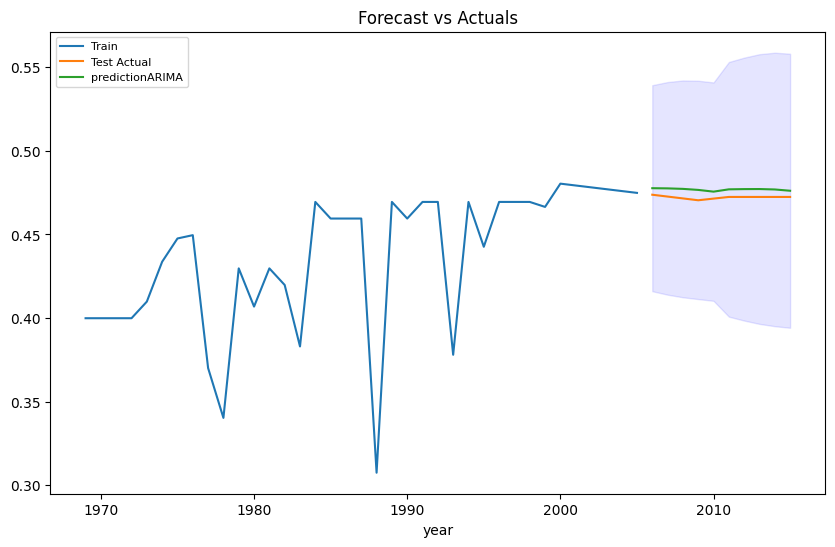

In [18]:
#Plot graphs
train.plot(legend=True, label='Train', figsize=(10,6)) # Plot train data
test.plot(legend=True, label='Test Actual') # Plot test data
pred.plot(legend=True, label='predictionARIMA') # Plot predicted values

#Calculate and plot confidence intervals
forecasts=model.get_forecast(len(test)) #95% confidence interval
ci=forecasts.conf_int()
ci.index = pred.index
lower_series = pd.Series(ci.loc[:,'lower gini_recalculated'])
upper_series = pd.Series(ci.loc[:,'upper gini_recalculated'])

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='b', alpha=.1)

#Title and legend
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 2.3 Repeating across all countries

In [19]:
best_pdq_dic = {}

def arima_country_predictions(gini_df_clean, country, ax):
    """
    Fits an ARIMA model for each country's Gini coefficient data and plots predictions.
    
    Parameters:
    - gini_df_clean: DataFrame containing Gini coefficient and year data for each country.
    - country: Country of choice
    - ax: axes to plot on
    """
    country_df = gini_df_clean.loc[gini_df_clean['country'] == country]
    if country_df['gini_recalculated'].nunique() <= 1:
        print(f"Skipping {country} because the Gini data is constant or insufficient.")
        return

    # Determine the order of differencing (d) needed for stationarity
    d = 0
    country_df_diffed = country_df.copy()
    while True:
        p_value = adfuller(country_df_diffed['gini_recalculated'].dropna().tolist())[1]
        if p_value <= 0.05:
            break
        country_df_diffed['gini_recalculated'] = country_df_diffed['gini_recalculated'].diff().dropna()
        d += 1

    # Train-test split
    train = country_df[:int(0.8 * len(country_df))]['gini_recalculated']
    test = country_df[int(0.8 * len(country_df)):]['gini_recalculated']

    # Define ranges for p and q, with d fixed
    p = range(0, 4)  # Reduced range for faster search
    q = range(0, 4)
    pdq_combinations = list(itertools.product(p, [d], q))

    # Store AIC, BIC, and parameters
    aic = []
    bic = []
    pdqCombs = []

    # Evaluate models and store AIC/BIC values
    for pdq in pdq_combinations:
        try:
            model = ARIMA(train, order=pdq).fit()
            aic.append(model.aic)
            bic.append(model.bic)
            pdqCombs.append(pdq)
        except Exception as e:
            print(f"Skipping model {pdq} for {country} due to error: {e}")
            continue

    # Collect results into DataFrame
    results = pd.DataFrame(index=pdqCombs, data=aic, columns=['AIC'])
    results['BIC'] = bic

    # Check if results DataFrame is empty (i.e., no valid models)
    if results.empty or (results['AIC'] == float('inf')).all():
        print(f"No valid models for {country}. Skipping.")
        return

    # Select the best model based on AIC or BIC
    min_aic = results['AIC'].min()
    min_bic = results['BIC'].min()
    if min_aic < min_bic:
        best_pdq = results['AIC'].idxmin()
    else:
        best_pdq = results['BIC'].idxmin()

    best_pdq_dic[country] = best_pdq

    # Fit the best model and make predictions
    model = ARIMA(train, order=best_pdq).fit()
    pred = model.predict(start=len(train), end=len(country_df) - 1)
    pred.index = test.index

    # Plotting
    train.plot(legend=True, label='Train', ax=ax)
    test.plot(legend=True, label='Test Actual', ax=ax)
    pred.plot(legend=True, label='ARIMA Prediction', ax=ax)

    # Confidence intervals
    forecasts = model.get_forecast(len(test))
    ci = forecasts.conf_int()
    ci.index = pred.index
    lower_series = ci.iloc[:, 0]
    upper_series = ci.iloc[:, 1]

    ax.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=0.1)
    ax.set_title(f"ARIMA Model for {country}")


        

In [20]:
def filter_countries(country):
    country_df = gini_df_clean.loc[gini_df_clean['country'] == country]
    


In [21]:
import math

all_countries = gini_df_clean['country'].unique()
num_countries = len(all_countries)
countries_per_row = 5

# Calculate the required number of rows
num_rows = math.ceil(num_countries / countries_per_row)

# Create subplots with the calculated number of rows and 5 columns
fig, axes = plt.subplots(num_rows, countries_per_row, figsize=(20, num_rows * 4))
axes = axes.flatten()

for i, country in enumerate(all_countries):
    arima_country_predictions(gini_df_clean, country, axes[i])
    print(f'Working on {country}')

for ax in fig.get_axes():
    # Check if the axis has any data (lines, collections, etc.)
    if not ax.has_data():
        fig.delaxes(ax)  # Delete the empty axis

# Adjust layout after deleting empty subplots
plt.tight_layout()
plt.show()


Working on Afghanistan
Working on Angola
Working on Albania
Skipping United Arab Emirates because the Gini data is constant or insufficient.
Working on United Arab Emirates
Working on Argentina
Working on Armenia
Working on Australia
Working on Austria
Working on Azerbaijan
Working on Burundi
Working on Belgium
Working on Benin
Working on Burkina Faso
Working on Bangladesh
Working on Bulgaria
Skipping Bahrain because the Gini data is constant or insufficient.
Working on Bahrain
Working on Bahamas
Working on Bosnia and Herzegovina
Working on Belarus
Working on Belize
Working on Bolivia
Working on Brazil
Working on Barbados
Working on Bhutan
Working on Botswana
Working on Central African Republic
Working on Canada
Working on Switzerland
Working on Chile
Working on China
Working on Cote dIvoire
Working on Cameroon
Working on Congo, the Democratic Republic of the
Working on Congo
Working on Colombia
Working on Comoros
Working on Cape Verde
Working on Costa Rica
Working on Cuba
Working on C

KeyboardInterrupt: 

In [ ]:
x = list(best_pdq_dic.values())
y = []
z = []
for i in x:
    y.append(i[0])
    z.append(i[2])

print(max(y))
print(max(z))

4
4


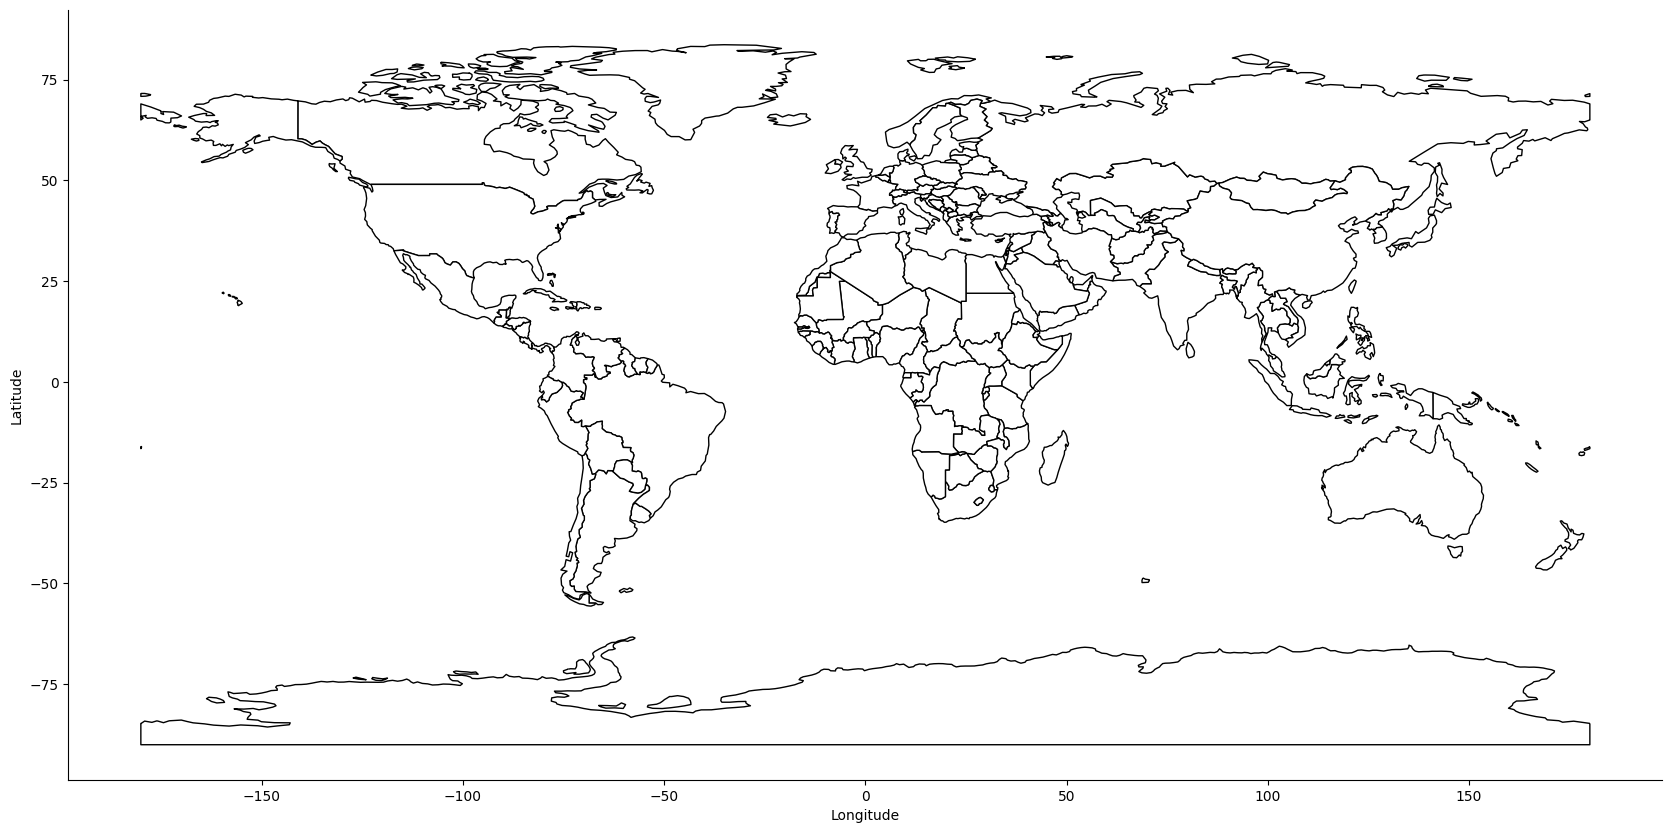

In [ ]:
import geopandas as gpd

# Get World Map data
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = world.set_index("ADM0_A3")
world_columns_req = ["ADMIN", "geometry"]
world_geom = world[world_columns_req]

world_geom.head()

# Plot world map

fig, ax = plt.subplots(figsize=(30,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world_geom.plot(ax=ax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()